## Step 10. Provide
- We use the prepared data from the previous step.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd
import numpy as np
from torch.optim import lr_scheduler
import time
import os
from tempfile import TemporaryDirectory

df = pd.read_csv('../data/ds_salaries_cleaned.csv')

## Step 11. Make available
- The data stored in a pandas dataframe and counts the number of job titles

In [2]:
print(df.shape)
df.head()

(3755, 9)


,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior-level/Expert,Full-Time,Data Scientist,85847,ES,100,ES,L
1,2023,Mid-level/Intermediate,Contract,ML Engineer,30000,US,100,US,S
2,2023,Mid-level/Intermediate,Contract,ML Engineer,25500,US,100,US,S
3,2023,Senior-level/Expert,Full-Time,Data Scientist,175000,CA,100,CA,M
4,2023,Senior-level/Expert,Full-Time,Data Scientist,120000,CA,100,CA,M


In [3]:
df["job_title"].value_counts()

job_title
Data Engineer                1110
Data Scientist                935
Data Analyst                  744
Machine Learning Engineer     333
Analytics Engineer            118
Applied Scientist             113
Data Science Manager          111
Data Architect                105
Research Scientist             93
Research Engineer              59
ML Engineer                    34
Name: count, dtype: int64

## Step 12. Select
We calculate the mean and standard deviation of the salary_in_usd column to get a sense of the distribution of the salaries
- The data are selected to be evaluated for an explicit analysis project. 

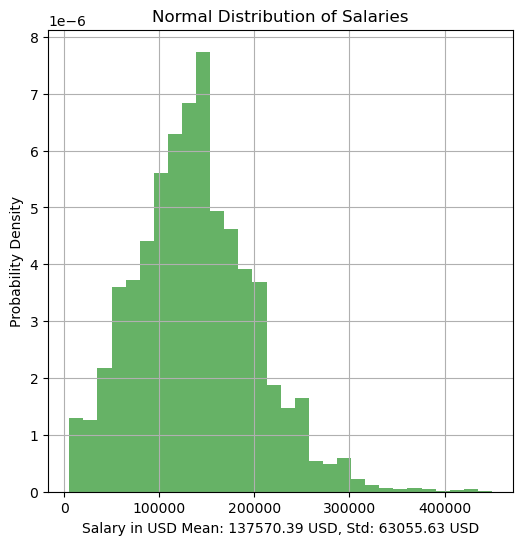

In [4]:
# draw a normalized histogram of the salary
import matplotlib.pyplot as plt
mean = df['salary_in_usd'].mean()
std = df['salary_in_usd'].std()

plt.figure(figsize=(6, 6))
# 'bins' specifies the number of bars in the histogram
# 'density' normalizes to keep the area under the histogram equal to 1
# 'alpha' sets the transparency level
plt.hist(df['salary_in_usd'], bins=30, density=True, alpha=0.6, color='g')
plt.title('Normal Distribution of Salaries')
plt.xlabel('Salary in USD Mean: {:.2f} USD, Std: {:.2f} USD'.format(mean, std))
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

We calculate and display a boxplot chart of the third quartile salaries for different job titles, sorted by their salary in descending order.

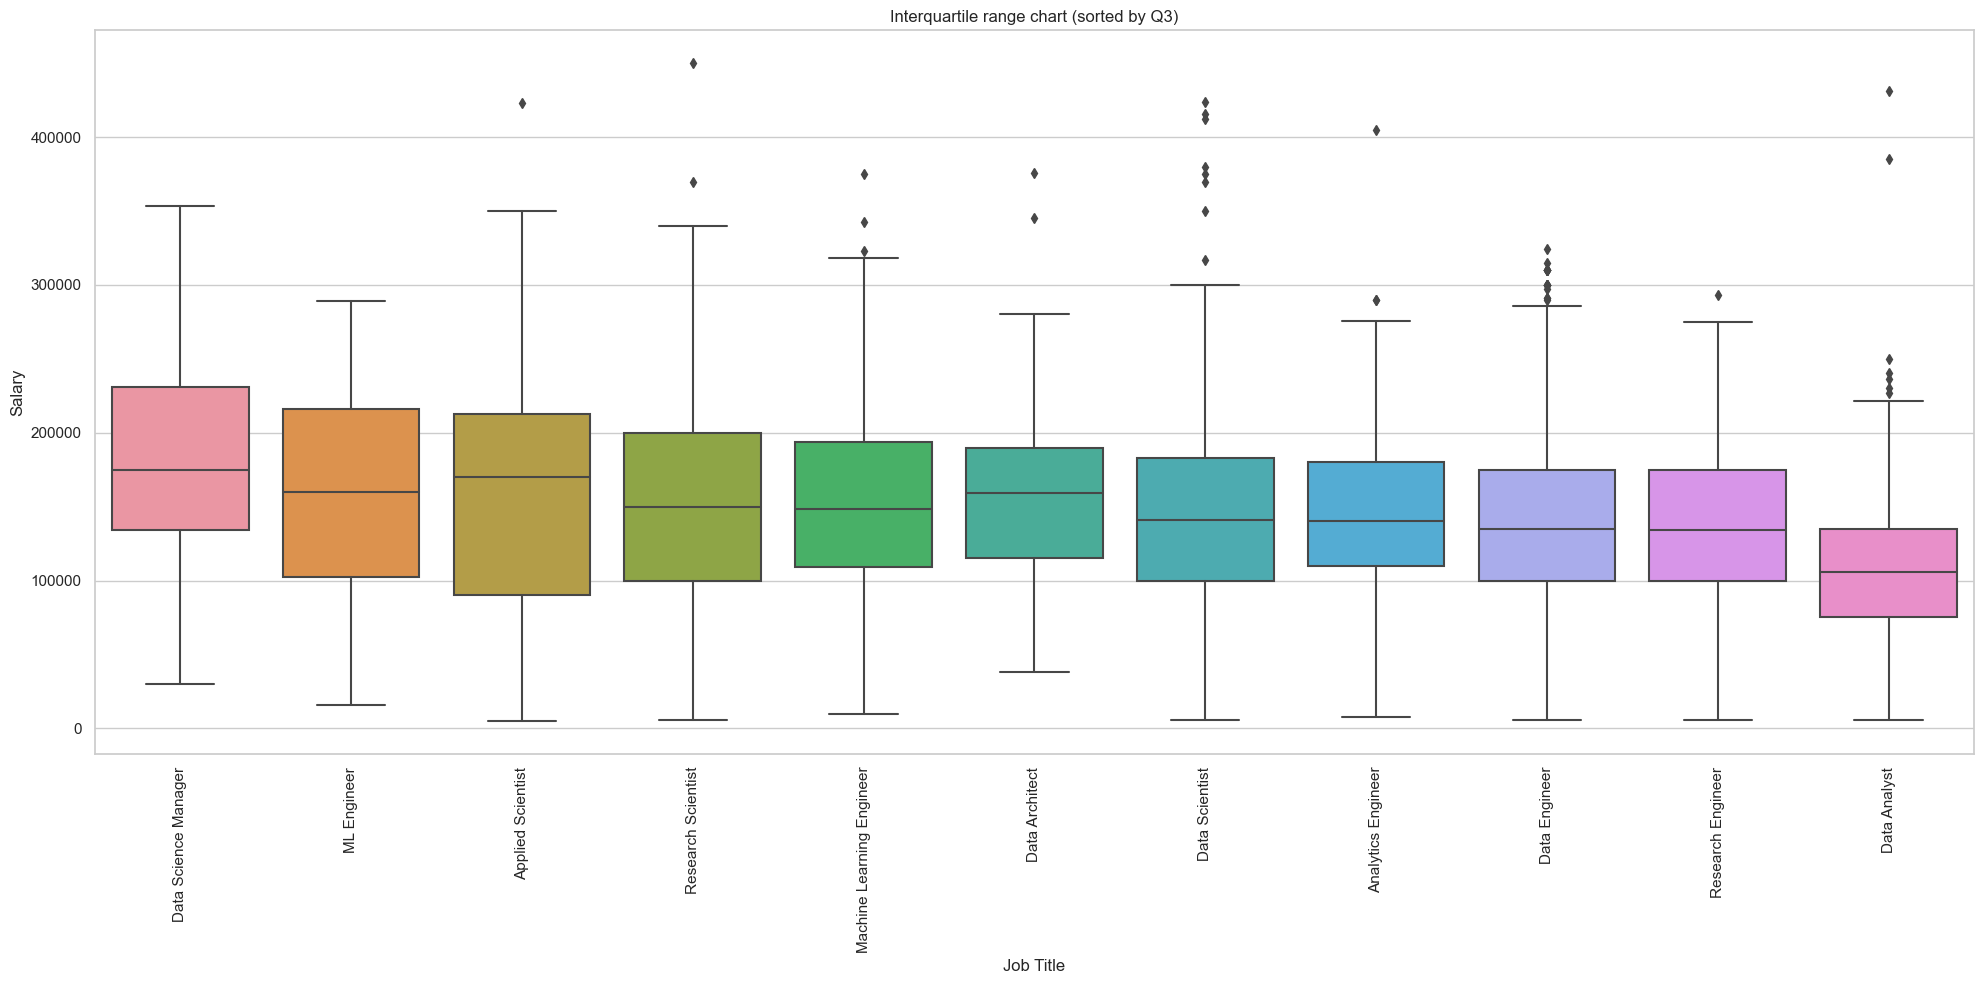

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the third quartile for each job position and sort them
q3_salaries = df.groupby('job_title')['salary_in_usd'].quantile(0.75).reset_index()
top_25_q3 = q3_salaries.sort_values(by='salary_in_usd', ascending=False)

# Create a chart with Seaborn style
sns.set(style="whitegrid")

# Use Seaborn's boxplot function to draw a quartile range chart
plt.figure(figsize=(20, 10))
sns.boxplot(x="job_title", y="salary_in_usd", data=df, order=top_25_q3['job_title'])
plt.xticks(rotation=90)  # Rotate the X-axis labels to avoid overlapping

# Add title and labels
plt.title("Interquartile range chart (sorted by Q3)")
plt.xlabel("Job Title")
plt.ylabel("Salary")

# Display the chart
plt.tight_layout()
plt.show()


## Step 13. Identify
Show the data properties in a table.
- The relevant properties for an explicit analysis project are identified.

In [6]:
# see the type of each column
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

## Step 14. Request
We adjust the salary label to 4 level, and we will use it as training data's label

In [7]:
# calculate the percentiles
def convertData(data):
    
    percentiles = np.percentile(df['salary_in_usd'], [25, 50, 75])  # 25th, 50th, 75th percentiles
    print(percentiles)
    # define the labels of saraly levels 
    labels = ['Level 1', 'Level 2', 'Level 3', 'Level 4']

    # print the meaning of label 
    for i in range(len(labels)):
        if i == 0:
            print('Level 1: < {:.2f} USD'.format(percentiles[i]))
        elif i == len(labels) - 1:
            print('Level {}: > {:.2f} USD'.format(i+1, percentiles[i-1]))
        else:
            print('Level {}: {:.2f} ~ {:.2f} USD'.format(i+1, percentiles[i-1], percentiles[i]))


    #  -np.inf, np.inf be the lower and upper bounds of the bins
    # *percentiles: base on the percentiles to cut the bins and generate the salary levels for being the labels of training data
    df['salary_level'] = pd.cut(df['salary_in_usd'], bins=[-np.inf, *percentiles, np.inf], labels=labels)
    data = df.drop(['salary_in_usd'], axis=1) # we cannot put the label into the training data
    print("\nThe data of each salary level is balanced.")
    print(data['salary_level'].value_counts())
    return data

data = convertData(df)
data
# each number of salary level have approximately the same number of data which occupy 25% of the whole data

[ 95000. 135000. 175000.]
Level 1: < 95000.00 USD
Level 2: 95000.00 ~ 135000.00 USD
Level 3: 135000.00 ~ 175000.00 USD
Level 4: > 175000.00 USD

The data of each salary level is balanced.
salary_level
Level 2    967
Level 1    956
Level 4    932
Level 3    900
Name: count, dtype: int64


,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_level
0,2023,Senior-level/Expert,Full-Time,Data Scientist,ES,100,ES,L,Level 1
1,2023,Mid-level/Intermediate,Contract,ML Engineer,US,100,US,S,Level 1
2,2023,Mid-level/Intermediate,Contract,ML Engineer,US,100,US,S,Level 1
3,2023,Senior-level/Expert,Full-Time,Data Scientist,CA,100,CA,M,Level 3
4,2023,Senior-level/Expert,Full-Time,Data Scientist,CA,100,CA,M,Level 2
...,...,...,...,...,...,...,...,...,...
3750,2020,Senior-level/Expert,Full-Time,Data Scientist,US,100,US,L,Level 4
3751,2021,Mid-level/Intermediate,Full-Time,Data Scientist,US,100,US,L,Level 3
3752,2020,Entry-level/Junior,Full-Time,Data Scientist,US,100,US,S,Level 2
3753,2020,Entry-level/Junior,Contract,Data Analyst,US,100,US,L,Level 2
